In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


2023-02-21 23:30:03.997657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [28]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


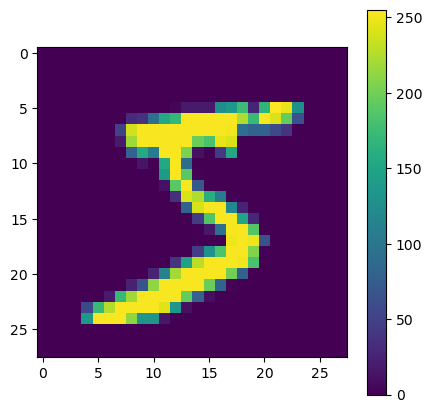

In [29]:
plt.figure(figsize=(5, 5))
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler

# X_train = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# X_test = np.array([[2, 4, 6], [5, 7, 9]])

scaler = StandardScaler()

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# X_train에 맞는 스케일러로 변형
x_train = scaler.fit_transform(x_train)

# X_test에도 해당 스케일러를 적용
x_test = scaler.transform(x_test)

x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)

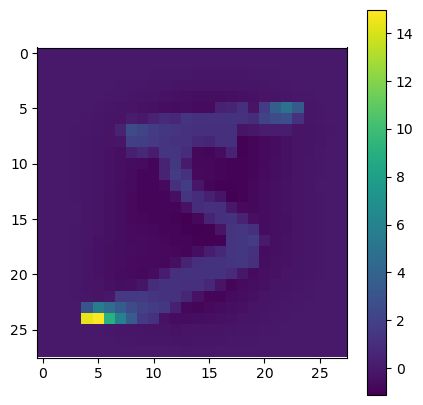

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(x_train_scaled[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [33]:
x_train.dtype

dtype('float64')

In [34]:
# Channel dimension 추가
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


In [36]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [48]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model


class MyModel(Model):
    def __init__(self):
        super().__init__()

        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation="relu")
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
    

model = MyModel()


In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [51]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [53]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        preds = model(images, training=True)
        loss = loss_object(labels, preds)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, preds)

In [54]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  preds = model(images, training=False)
  t_loss = loss_object(labels, preds)

  test_loss(t_loss)
  test_accuracy(labels, preds)

In [56]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.17458397150039673, Accuracy: 95.02999877929688, Test Loss: 0.10268440842628479, Test Accuracy: 97.29999542236328
Epoch 2, Loss: 0.06426841765642166, Accuracy: 98.20333099365234, Test Loss: 0.10218904167413712, Test Accuracy: 97.70999908447266
Epoch 3, Loss: 0.03930743411183357, Accuracy: 98.95500183105469, Test Loss: 0.11327753216028214, Test Accuracy: 97.7699966430664
Epoch 4, Loss: 0.026052750647068024, Accuracy: 99.27166748046875, Test Loss: 0.09844457358121872, Test Accuracy: 97.80999755859375
Epoch 5, Loss: 0.017813151702284813, Accuracy: 99.44999694824219, Test Loss: 0.11556421965360641, Test Accuracy: 97.79999542236328
